In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from wordcloud import WordCloud, STOPWORDS
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\EFERRANCULLO\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\EFERRANCULLO\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## Opening the Dataset and removing null values

In [2]:
df = pd.read_csv("Twitter_Data.csv")
df.head()

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [3]:
df.category.unique()

array([-1.,  0.,  1., nan])

**Check for null values**

In [4]:
df.isna().sum()

clean_text    5
category      7
dtype: int64

**Deleting the null values**

In [5]:
df.drop(df[df['clean_text'].isna()].index, inplace=True)
df.drop(df[df['category'].isna()].index, inplace=True)

In [6]:
df.isna().sum()

clean_text    0
category      0
dtype: int64

**Checking the count of remaining data**

In [7]:
df.count()

clean_text    162968
category      162968
dtype: int64

## Checking the Distribution of Tweets

In [8]:
neutral_tweets = df[df['category'] == 0]
positive_tweets = df[df['category'] == 1]
negative_tweets = df[df['category'] == -1]
tweet_count = [neutral_tweets.count().values[0],positive_tweets.count().values[0],negative_tweets.count().values[0]]

neutral tweets: 55210
positive tweets: 72249
negative tweets: 35509
total: 162968


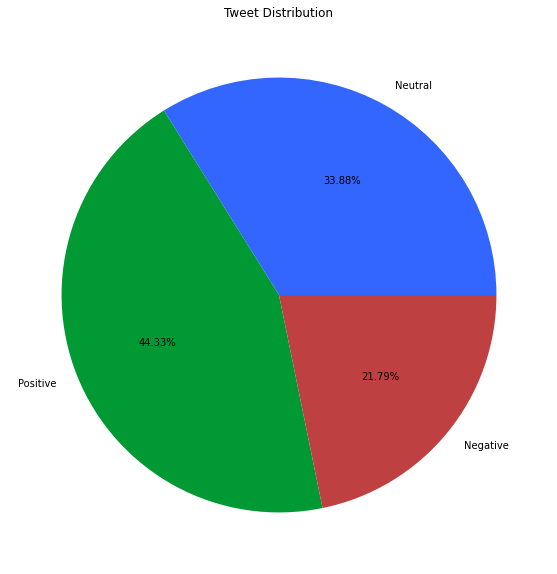

In [9]:
tweet_data = {'count':tweet_count}
table_label = ['Neutral','Positive','Negative']
table_colors = ['#3366ff','#009933','#bf4040']
tweet_count_df = pd.DataFrame(tweet_data,columns=['count'])

plt.figure(figsize = (10,10))
plt.pie(tweet_count_df['count'],labels = table_label,colors=table_colors,autopct='%1.2f%%');
plt.title("Tweet Distribution")
print(f'neutral tweets: {tweet_count[0]}')
print(f'positive tweets: {tweet_count[1]}')
print(f'negative tweets: {tweet_count[2]}')
print(f'total: {sum(tweet_count)}')

## Interpreting the Data

The subfield of AI that deals with this kind of data is called NLP.
<br>One of the most common visualization in this field is word cloud.
<br><br> To start with word cloud, we need to gather the most common words per tweet classification.
<br><br>Before moving to the the analyzation, we can remove the common words that has no effect in the sentiment of the text.
<br>This is built-in from STOPWORDS from wordcloud.

In [10]:
# get the stopwords as these do not affect the tweet classification
stopwords = set(STOPWORDS)

Another thing we need to do prior to analysis is processing the text.
<br>We need to consider if there are url's, tagged user, and non-alphanumeric characters and transform them accordingly.
<br>
- For urls we will replace them with 'URL'
- For tagged user we will replace them with 'USER'
- For non-alphanumeric characters we will replace them with space

<br>We also need to consider the base form of words and integrate them to our analysis.
<br>For example: caring and careful will be transformed to care
<br>To do this we will use [Lemmatizer](https://www.machinelearningplus.com/nlp/lemmatization-examples-python/)
<br>
<br>We will create a function for this because so it can be reused for future data.

In [11]:
def process_text(textinput):
    processedText = []
    
    # Lemmatizer
    wordLemm = WordNetLemmatizer()

    # Regex Patterns
    urlPattern = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    taggedUser = '@[^\s]+'
    alphanumeric = "[^a-zA-Z0-9]"
    
    for tweet in textinput:
        tweet = tweet.lower() # transform tweet lowercase
        tweet = re.sub(urlPattern,' URL',tweet) # transform URLs to 'URL'
        tweet = re.sub(taggedUser,' USER', tweet) # replace @USER to 'USER'
        tweet = re.sub(alphanumeric, " ", tweet) # Replace all non-alphanumeric.
        
        tweetwords = '' # create a placeholder for all the words
        
        for word in tweet.split():
            #check if word is not a space
            if len(word)>1:
                word = wordLemm.lemmatize(word)
                tweetwords += f'{word} '
                
        processedText.append(tweetwords)
        
    return processedText

**Process the neutral, positive and negative tweets**

In [12]:
neutral = list(neutral_tweets['clean_text'])
positive = list(positive_tweets['clean_text'])
negative = list(negative_tweets['clean_text'])
all_tweets = list(df['clean_text'])
sentiment = list(df['category'])

neutral_processed = process_text(neutral)
positive_processed = process_text(positive)
negative_processed = process_text(negative)
all_processed = process_text(all_tweets)

**Creating WordCloud for neutral tweets**

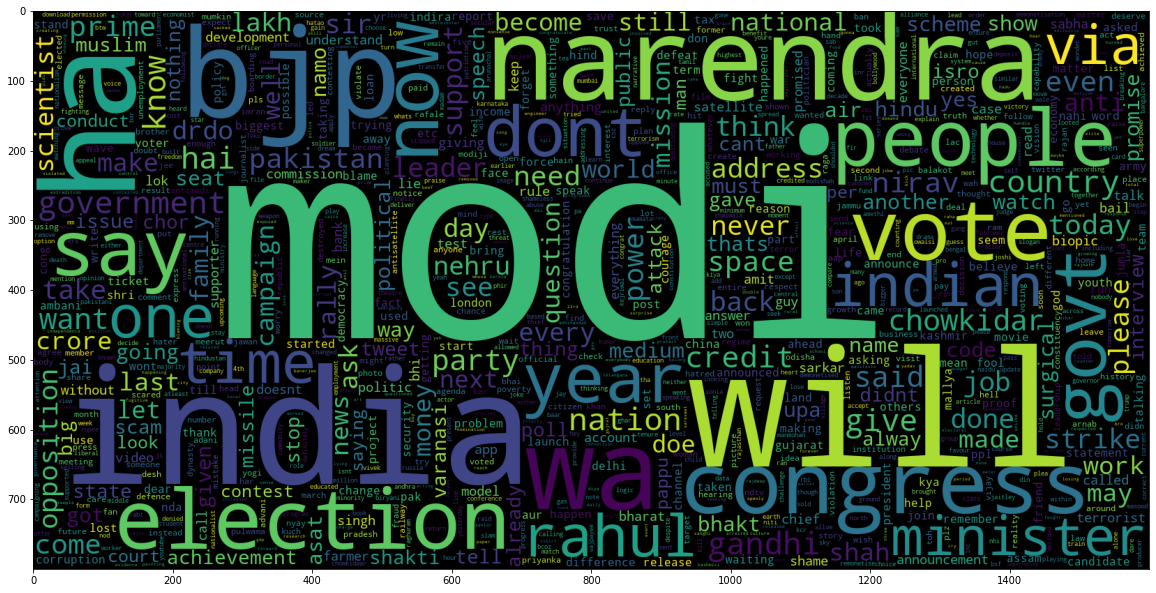

In [13]:
data_neutral = neutral_processed
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neutral))
plt.imshow(wc)

**Creating WordCloud for positive tweets**

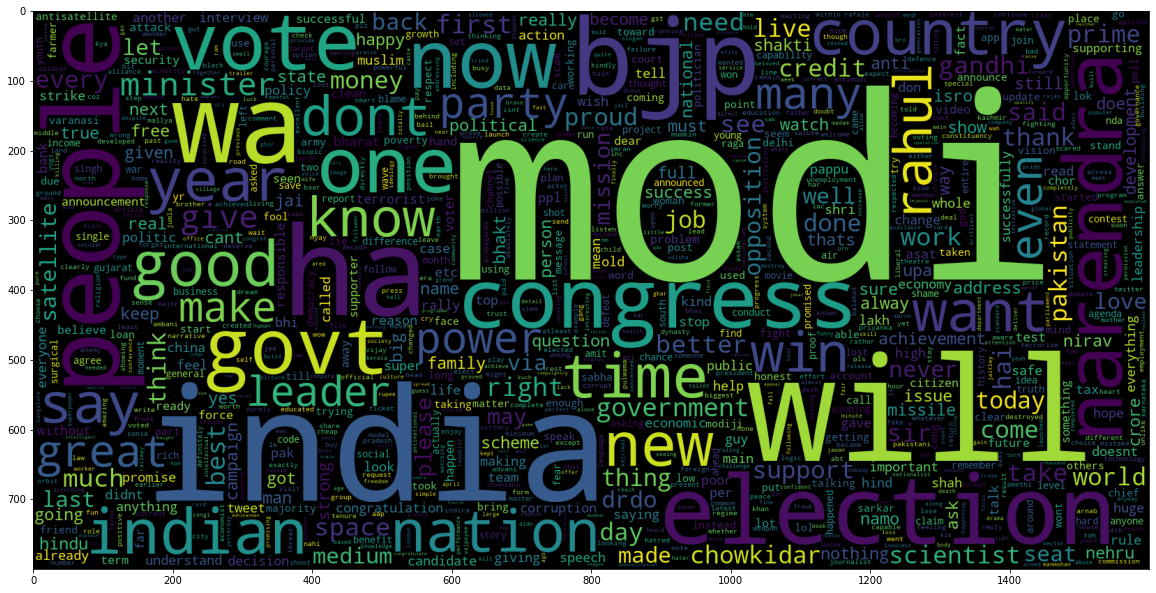

In [14]:
data_positive = positive_processed
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_positive))
plt.imshow(wc)

**Creating WordCloud for negative tweets**

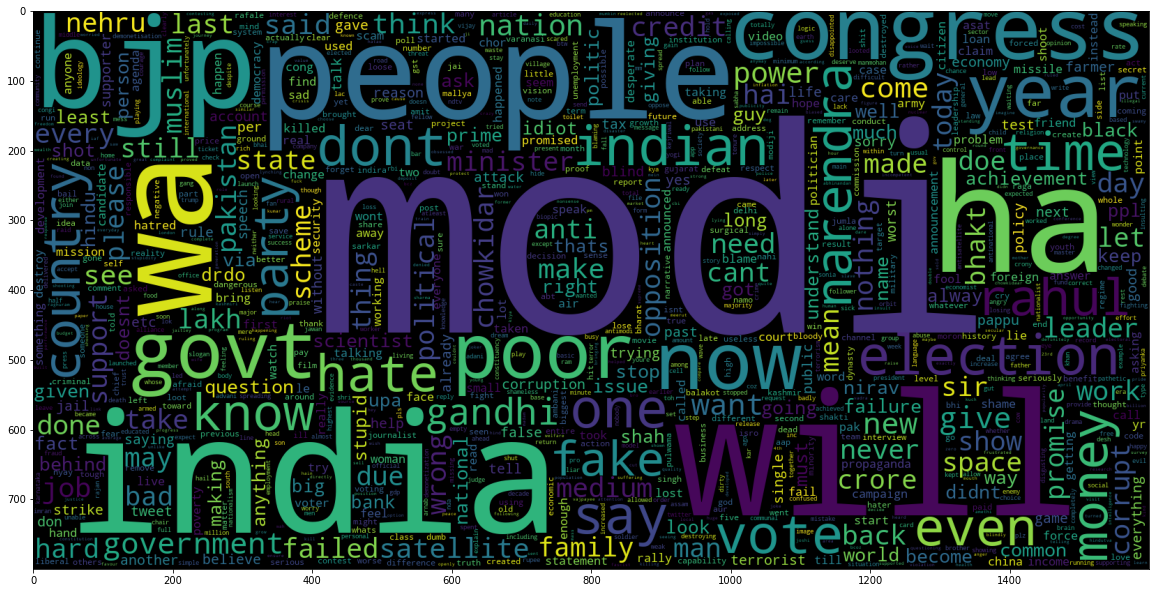

In [15]:
data_negative = negative_processed
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_negative))
plt.imshow(wc)

## Creating the Model


Splitting the data for testing and training

In [16]:
X_train, X_test, y_train, y_test = train_test_split(all_processed, sentiment,
                                                    test_size = 0.2, random_state = 0)

Let us assess what words are more important. This can be done by comparing its frequency versus other words in the dataset.
<br>The tool we can use for this is TF-IDF Vectoriser .

In [17]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000) # ngram range to consider grouping of 2 consecutive words
vectoriser.fit(X_train)
print(f'Vectoriser fitted.')
print('No. of feature_words: ', len(vectoriser.get_feature_names_out())) 
# no of max features lowered due to error when predicting data

Vectoriser fitted.
No. of feature_words:  500000


**Transform the dataset to TF-IDF Matrix**

In [18]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

**From our lectures, we can use Logistic Regression to predict categorical outcomes unlike linear regression that predicts a continuous outcome.**

In [19]:
logr = LogisticRegression(max_iter = 1000) # Initialize model
logr.fit(X_train,y_train) # Fit the data
y_predicted = logr.predict(X_test)# Predict the data

**Evaluating our model**

We can get the accuracy of our model using the **<em>accuracy_score</em>** from **<em>sklearn.metrics</em>**

In [20]:
model_accuracy = accuracy_score(y_test,y_predicted)
print(f'Logistic Regression accuracy is {round(model_accuracy*100,2)}%')

Logistic Regression accuracy is 89.51%


Since our model's accuracy is close to 90%, we can now create a function to predict sentiment of texts

**Creating a function using our model:**

In [36]:
def tweet_sentiment(vectoriser,model,text):
    textdata = vectoriser.transform(process_text(text)) # process data using the defined function
    sentiment = model.predict(textdata) # predict sentiment of data using the model
    
    # Display as list with matching sentiment
    data = []
    for text, pred in zip(text, sentiment):
        data.append((text,pred)) # append the pair to data
        
    # Convert the list into a Pandas DataFrame.
    df = pd.DataFrame(data, columns = ['text','sentiment'])
    df = df.replace([-1,0,1],["Negative","Neutral","Positive"])
    return df

**Testing the Function**

In [41]:
sample_text = ["With great power comes great responsibility",
            "THAT'S MY SECRET, CAPTAIN. I'M ALWAYS ANGRY",
            "I'll be back"]

df = tweet_sentiment(vectoriser,logr,sample_text)
print(df.head())

                                          text sentiment
0  With great power comes great responsibility  Positive
1  THAT'S MY SECRET, CAPTAIN. I'M ALWAYS ANGRY  Negative
2                                 I'll be back   Neutral
